In [357]:
import pickle, glob, json, os, zipfile, io
import numpy as np
import matplotlib.pyplot as plt
import functools

BRUSH_DIR = "./data/BRUSH_small/"

In [170]:
def plot_strokes(stroke, title, fig=None, ax=None):
    """Plot a single stroke"""
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12, 2))

    # Separate strokes based on pen lifts
    strokes = []
    current_stroke = []
    for point in stroke:
        if point[2] == 1:  # Pen is down
            current_stroke.append(point)
        else:  # Pen is up
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
    if current_stroke:
        strokes.append(current_stroke)

    # Plot each stroke
    for stroke in strokes:
        x, y = zip(*[(p[0], 1 - p[1]) for p in stroke])  # Invert y-axis
        ax.plot(x, y, 'b-')

    ax.set_aspect('equal') ; ax.set_title(title)
    if fig is None: plt.show()
    return fig, ax

(<Figure size 1200x200 with 1 Axes>,
 <Axes: title={'center': 'Wordsworth Alonzo'}>)

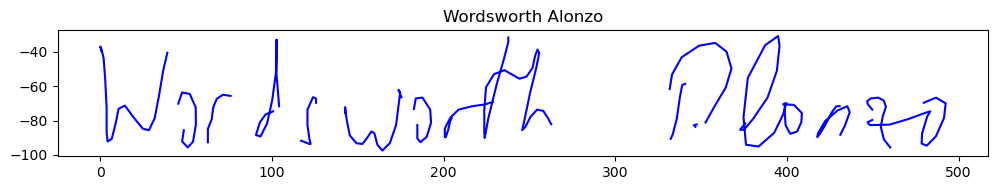

In [184]:
writer_ids = [p.split('/')[-1] for p in glob.glob(BRUSH_DIR + '*')]
writer_id = writer_ids[0]
drawing_ids = [p.split('/')[-1] for p in glob.glob(BRUSH_DIR + f"{writer_id}/*") if '_' not in p.split('/')[-1]]

writer_id = np.random.randint(len(writer_ids))
drawing_id = np.random.randint(len(drawing_ids))
with open(BRUSH_DIR + f"{writer_id}/{drawing_id}", 'rb') as f:
  [sentence, drawing, label] = pickle.load(f)

plot_strokes([(x, y, 1-eos) for x, y, eos in drawing], sentence)

## Load the whole dataset

In [297]:
@functools.lru_cache(maxsize=5)
def load_and_parse_brush_data(data_dir):
    data = []
    writer_ids = [p.split('/')[-1] for p in glob.glob(f"{data_dir}*")]
    
    for writer_id in writer_ids:
        drawing_ids = [p.split('/')[-1] for p in glob.glob(f"{data_dir}{writer_id}/*") if '_' not in p.split('/')[-1]]
        for drawing_id in drawing_ids:
            
            with open(f"{data_dir}/{writer_id}/{drawing_id}", 'rb') as f:
                [sentence, drawing, label] = pickle.load(f)
                
            strokes = np.array(drawing)
            strokes[:, 2] = 1 - strokes[:, 2]  # convert eos to pen-down state
            strokes[:, 1] = (strokes[:, 1] - 40)/90
            strokes[:, 0] -= strokes[0, 0]
            
            data.append({
                'points': strokes,
                'metadata': {'asciiSequence': sentence, 'aspectRatio': 1, 'writerId': writer_id, 'drawingId': drawing_id, 'label': label}})
    return data

In [327]:
data = load_and_parse_brush_data(data_dir=BRUSH_DIR)
print(len(data))

k = 900
data[k]['points'][:,1].min(), data[k]['points'][:,1].max()

1272


(0.17569444444444443, 0.8633928571428571)

In [333]:
def save_json_to_brush_format(json_data, output_dir, author_to_id_map=None):
    if author_to_id_map is None:
        author_to_id_map = {}

    for item in json_data:
        metadata = item['metadata']
        points = np.array(item['points'])

        sentence = metadata['asciiSequence']
        author = metadata.get('author', 'unknown')
        writer_id = author_to_id_map.get(author, author)

        drawing = points[:, :3]  # Assuming the first 3 columns are x, y, and eos
        drawing[:, 2] = 1 - drawing[:, 2]  # Convert pen-down state to eos

        label = np.zeros((len(drawing), len(sentence)))  # Create label data (simplified version without character-level labeling)
        
        writer_dir = os.path.join(output_dir, str(writer_id))  # Create writer directory if it doesn't exist
        os.makedirs(writer_dir, exist_ok=True)

        drawing_id = str(len(os.listdir(writer_dir))) # Generate a unique drawing_id
        with open(os.path.join(writer_dir, drawing_id), 'wb') as f:
            pickle.dump([sentence, drawing.tolist(), label.tolist()], f)

    print(f"Data saved successfully in {output_dir}")

In [343]:
TARGET_DIR = "./data/BIGBANK_PRINT/"
author_to_id_map = {'unknown':0, 'Sam': 1, 'SamPrint':2}

json_file_path = "./data/1197-bigbank-print.json"
with open(json_file_path, 'r') as f:
    json_data = json.load(f)

In [345]:
save_json_to_brush_format(json_data, output_dir=TARGET_DIR, author_to_id_map=author_to_id_map)

Data saved successfully in ./data/BIGBANK_PRINT/


In [401]:
@functools.lru_cache(maxsize=5)
def load_and_parse_brush_data(base_name, data_dir='./data'):
    data_zip = os.path.join(data_dir, f"{base_name}.zip")
    data = []
    with zipfile.ZipFile(data_zip, 'r') as zip_ref:
        writer_ids = set(name.split('/')[1] for name in zip_ref.namelist() 
                         if name.startswith(f"{base_name}/") and name.count('/') > 1)
        
        for writer_id in writer_ids:
            drawing_ids = [name.split('/')[-1] for name in zip_ref.namelist() 
                           if name.startswith(f"{base_name}/{writer_id}/") 
                           and name.count('/') == 2 and name[-1] != '/']
            
            for drawing_id in drawing_ids:
                try:
                    with zip_ref.open(f"{base_name}/{writer_id}/{drawing_id}") as f:
                        file_content = f.read()
                        if not file_content:  # Skip empty files
                            continue
                        [sentence, drawing, label] = pickle.load(io.BytesIO(file_content))
                    
                    strokes = np.array(drawing)
                    strokes[:, 2] = 1 - strokes[:, 2]  # convert eos to pen-down state
                    if 'BRUSH' in base_name:
                        strokes[:, 1] = (strokes[:, 1] - 40)/90
                    strokes[:, 0] -= strokes[0, 0]
                    
                    data.append({
                        'points': strokes,
                        'metadata': {'asciiSequence': sentence, 'aspectRatio': 1, 
                                     'writerId': writer_id, 'drawingId': drawing_id, 'label': label}})
                except (EOFError, pickle.UnpicklingError, ValueError) as e:
                    print(f"Error processing file {base_name}/{writer_id}/{drawing_id}: {str(e)}")
                    continue
    return data

data = load_and_parse_brush_data(base_name='BRUSH_small')
print(len(data))

k = 400
data[k]['points'][:,1].min(), data[k]['points'][:,1].max()

1272


(0.15367658278521368, 0.8152657826741536)